In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [1]:
import ot

/Users/peter/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('Power Plant Data.csv')

df_sorted = df.sort_values(by='AT', ascending=True).reset_index(drop=True)

#  Define the Split Cutoff (70% Source / 30% Target)
split_idx = int(0.7 * len(df_sorted))

#  Create the Partition
# Source (Train): The coldest 70%
df_source = df_sorted.iloc[:split_idx]
Xs = df_source[['AT', 'V', 'AP', 'RH']].values
Ys = df_source['PE'].values

In [6]:
# Target (Test): The hottest 30%
df_target = df_sorted.iloc[split_idx:]
Xt = df_target[['AT', 'V', 'AP', 'RH']].values
Yt = df_target['PE'].values

# 5. Normalize (CRITICAL for Optimal Transport)
# OT is sensitive to scale. You must normalize based on the SOURCE stats.
scaler = StandardScaler()
Xs_scaled = scaler.fit_transform(Xs)
Xt_scaled = scaler.transform(Xt)  # Apply source scaling to target

In [ ]:
from numpyro.infer import Predictive

In [63]:
# 1. Compute Sinkhorn (Same as before)
# 1. Setup Uniform Distributions (The "Prior" belief)
n_source = len(Xs_scaled)
n_target = len(Xt_scaled)
a = np.ones(n_source) / n_source
b = np.ones(n_target) / n_target

# 2. Compute Cost Matrix (Squared Euclidean)
M = ot.dist(Xs_scaled, Xt_scaled, metric='sqeuclidean')

# 3. Compute Unbalanced Transport Plan
# reg = 0.1 (Entropy), reg_m = 1.0 (Marginal Relaxation)
gamma_unbalanced = ot.unbalanced.sinkhorn_unbalanced(
    a, b, M, reg=0.05, reg_m=1.0)

# 4. Extract Importance Weights
# Summing over the target columns tells us how much "mass" each source point contributed
# We multiply by n_source to center the weights around 1.0
weights = np.sum(gamma_unbalanced, axis=1) * n_source

# 5. Sanity Check
print(f"Max Weight: {weights.max():.2f}")  # Should be > 1 (Useful points)
print(f"Min Weight: {weights.min():.2f}")  # Should be < 1 (Useless points)

Max Weight: 6.09
Min Weight: 0.00


In [64]:
def robust_weighted_regression(X, Y=None, weights=None):
    n_obs, n_features = X.shape

    # --- FIX STARTS HERE ---
    # 1. Determine Prior Mean safely
    # If we are training, use data statistics. If predicting (Y=None), use defaults.
    if Y is not None:
        y_mean_prior = jnp.mean(Y)
        y_scale_prior = jnp.std(Y)
    else:
        # Defaults for prediction (doesn't impact posterior, just placeholder for shape)
        y_mean_prior = 0.0
        y_scale_prior = 100.0

    # 2. Intercept (Alpha)
    # Now use the safe variable 'y_mean_prior'
    alpha = numpyro.sample('alpha', dist.Normal(y_mean_prior, 100.0))

    # 3. Sigma
    sigma = numpyro.sample('sigma', dist.HalfNormal(y_scale_prior))
    # --- FIX ENDS HERE ---

    # Weights (Beta)
    beta = numpyro.sample('beta', dist.Normal(0.0, 1.0).expand([n_features]))

    # Degrees of freedom for Student-T
    nu = numpyro.sample('nu', dist.Gamma(2.0, 0.1))

    # Deterministic Mean
    mu = alpha + jnp.dot(X, beta)

    # Likelihood
    with numpyro.plate('data', n_obs):
        obs_dist = dist.StudentT(nu, mu, sigma)

        # Sample (Condition on Y if it exists)
        numpyro.sample('obs', obs_dist, obs=Y)

        # Weighting (Only if we have weights AND data)
        if weights is not None and Y is not None:
            log_prob = obs_dist.log_prob(Y)
            numpyro.factor('obs_weighting', (weights - 1) * log_prob)

In [65]:
# 1. Prepare Data for JAX
# Use the ORIGINAL Scaled Source Data (Not Transported features!)
X_train = jnp.array(Xs_scaled)
Y_train = jnp.array(Ys)
# Use the weights you calculated from Unbalanced Sinkhorn
weights_jax = jnp.array(weights)

# 2. Setup the NUTS Kernel with your Weighted Model
# We pass the model function we defined earlier
nuts_kernel = NUTS(robust_weighted_regression)

# 3. Configure the MCMC Runner
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=2
)

# 4. Run the Inference (The "Fit")
print("Starting Weighted HMC Sampling...")
mcmc.run(
    jax.random.PRNGKey(42),
    X=X_train,
    Y=Y_train,
    weights=weights_jax  # <--- This is the magic link
)

# 5. Get Your Results
posterior_samples = mcmc.get_samples()
print("Inference Complete.")

/var/folders/zl/1dq1dqcj2d37cy0lyvfcht340000gn/T/ipykernel_14132/227576663.py:13: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Starting Weighted HMC Sampling...


sample: 100%|██████████| 3000/3000 [00:14<00:00, 203.02it/s, 15 steps of size 1.91e-01. acc. prob=0.91]

Inference Complete.


In [66]:
Xt_scaled_jax = jnp.array(Xt_scaled)

# 2. Instantiate Predictive
# We pass the posterior samples we just learned
predictive = Predictive(robust_weighted_regression, posterior_samples)

# 3. Run Prediction
# We are asking: "Given the learned parameters, what should Y be for these X values?"
predictions = predictive(
    jax.random.PRNGKey(1), 
    X=Xt_scaled_jax, 
    Y=None, 
    weights=None
)

# 4. Extract the samples
# Shape: (num_samples, n_test_points) e.g., (2000, 2871)
Y_pred_samples = predictions['obs']

In [67]:
y_mean = np.mean(Y_pred_samples, axis=0)
y_lower = np.percentile(Y_pred_samples, 2.5, axis=0)
y_upper = np.percentile(Y_pred_samples, 97.5, axis=0)

# --- B. Sorting (Crucial for clarity) ---
# Sort by the TRUE Target values (Yt) to create the S-curve
sort_idx = np.argsort(Yt)  # Yt is the real power output of the target set
Yt_sorted = Yt[sort_idx]
y_mean_sorted = y_mean[sort_idx]
y_lower_sorted = y_lower[sort_idx]
y_upper_sorted = y_upper[sort_idx]



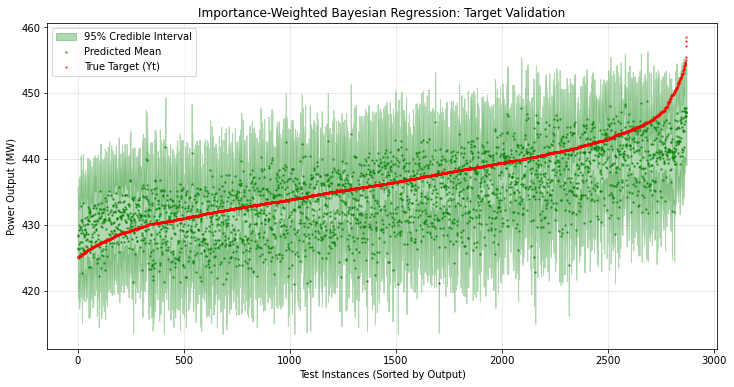

In [68]:
# --- C. Plotting ---
plt.figure(figsize=(12, 6))

# 1. The Uncertainty Band (Your "Robustness")
plt.fill_between(range(len(Yt)), y_lower_sorted, y_upper_sorted,
                 color='green', alpha=0.3, label='95% Credible Interval')

# 2. The Mean Prediction
plt.scatter(range(len(Yt)), y_mean_sorted, color='green',
            s=2, alpha=0.6, label='Predicted Mean')

# 3. The Truth (Target Data)
plt.scatter(range(len(Yt)), Yt_sorted, color='red',
            s=2, alpha=0.6, label='True Target (Yt)')

plt.title("Importance-Weighted Bayesian Regression: Target Validation")
plt.xlabel("Test Instances (Sorted by Output)")
plt.ylabel("Power Output (MW)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [69]:
def calculate_metrics(y_true, y_pred_samples, model_name):
    # 1. Point Prediction (Use Mean of samples)
    y_pred_mean = np.mean(y_pred_samples, axis=0)

    # 2. Uncertainty Interval (95%)
    y_lower = np.percentile(y_pred_samples, 2.5, axis=0)
    y_upper = np.percentile(y_pred_samples, 97.5, axis=0)

    # --- Metrics ---

    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(y_pred_mean - y_true))

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean((y_pred_mean - y_true)**2))

    # Coverage (Target: 0.95)
    in_interval = (y_true >= y_lower) & (y_true <= y_upper)
    coverage = np.mean(in_interval)

    # Interval Width (Sharpness) - Smaller is better (if coverage is good)
    width = np.mean(y_upper - y_lower)

    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "Coverage (95%)": coverage,
        "Avg Interval Width": width
    }


# Calculate for both
metrics_baseline = calculate_metrics(Yt, Y_pred_baseline, "Baseline (Naive)")
metrics_weighted = calculate_metrics(Yt, Y_pred_samples, "OT-Weighted (Ours)")

# Display as a clear table
results_df = pd.DataFrame([metrics_baseline, metrics_weighted])
print(results_df.round(3))

                Model    MAE   RMSE  Coverage (95%)  Avg Interval Width
0    Baseline (Naive)  4.836  6.166           0.808              16.911
1  OT-Weighted (Ours)  4.049  5.092           0.850              15.013


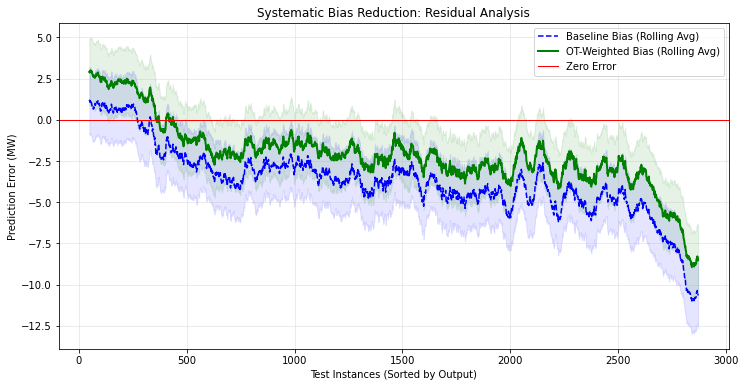

In [70]:
# 1. Calculate Residuals
resid_base = y_mean_base[sort_idx] - Yt[sort_idx]
resid_weight = y_mean_sorted - Yt[sort_idx]  # y_mean_sorted is your OT model

# 2. Smooth them for plotting (Rolling mean makes trends visible vs noise)
window = 50
smooth_base = pd.Series(resid_base).rolling(window=window).mean()
smooth_weight = pd.Series(resid_weight).rolling(window=window).mean()

plt.figure(figsize=(12, 6))

# Plot Baseline Error
plt.plot(smooth_base, color='blue',
         linestyle='--', label='Baseline Bias (Rolling Avg)')
plt.fill_between(range(len(Yt)), smooth_base - 2,
                 smooth_base + 2, color='blue', alpha=0.1)

# Plot Weighted Error
plt.plot(smooth_weight, color='green',
         linewidth=2, label='OT-Weighted Bias (Rolling Avg)')
plt.fill_between(range(len(Yt)), smooth_weight - 2,
                 smooth_weight + 2, color='green', alpha=0.1)

# Reference line at 0 (Perfect Prediction)
plt.axhline(0, color='red', linewidth=1, linestyle='-', label='Zero Error')

plt.title("Systematic Bias Reduction: Residual Analysis")
plt.xlabel("Test Instances (Sorted by Output)")
plt.ylabel("Prediction Error (MW)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()